<a href="https://colab.research.google.com/github/amirkasaei/Compositional-Noise-Optimization/blob/main/Compositional_Metric_Evaluation.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

## Setup & utils

In [ ]:
from abc import ABC, abstractmethod

import torch


class BaseRewardLoss(ABC):
    """
    Base class for reward functions implementing a differentiable reward function for optimization.
    """

    def __init__(self, name: str, weighting: float):
        self.name = name
        self.weighting = weighting

    @staticmethod
    def freeze_parameters(params: torch.nn.ParameterList):
        for param in params:
            param.requires_grad = False

    @abstractmethod
    def get_image_features(self, image: torch.Tensor) -> torch.Tensor:
        pass

    @abstractmethod
    def get_text_features(self, prompt: str) -> torch.Tensor:
        pass

    @abstractmethod
    def compute(
        self, image_features: torch.Tensor, text_features: torch.Tensor
    ) -> torch.Tensor:
        pass

    def process_features(self, features: torch.Tensor) -> torch.Tensor:
        features_normed = features / features.norm(dim=-1, keepdim=True)
        return features_normed

    def __call__(self, img_path: str, prompt: str) -> torch.Tensor:
        img = Image.open(img_path)
        preprocessed_img = clip_img_transform(224)(img)
        image = preprocessed_img.unsqueeze(0).to(device)

        image_features = self.get_image_features(image)
        text_features = self.get_text_features(prompt)

        image_features_normed = self.process_features(image_features)
        text_features_normed = self.process_features(text_features)

        score, loss = self.compute(image_features_normed, text_features_normed)
        return score, loss


In [ ]:
!pip install gdown
!gdown "https://drive.google.com/uc?id=1BUT7xbfOCx4cKu9A5fAxHs5UGvTPfyrV"

Downloading...
From (original): https://drive.google.com/uc?id=1BUT7xbfOCx4cKu9A5fAxHs5UGvTPfyrV
From (redirected): https://drive.google.com/uc?id=1BUT7xbfOCx4cKu9A5fAxHs5UGvTPfyrV&confirm=t&uuid=b378cb60-8d58-4904-9595-2b85ea0d844d
To: /content/human_eval_images_T2I_Compbench.rar
100% 1.02G/1.02G [00:12<00:00, 78.8MB/s]


In [ ]:
# Add the dataset to your drive and mount your drive on colab
RAR_FILE_PATH = "/content/human_eval_images_T2I_Compbench.rar"
EXTRACTION_PATH = "human_eval_images_T2I_Compbench"

In [ ]:
import pandas as pd

! pip install rarfile
import rarfile
import os

os.makedirs(EXTRACTION_PATH, exist_ok=True)

if not os.listdir(EXTRACTION_PATH):
    print("Extracting the RAR file as the directory is empty.")

    # Extract the .rar file
    with rarfile.RarFile(RAR_FILE_PATH) as rf:
        rf.extractall(EXTRACTION_PATH)
else:
    print("The directory already contains files. Skipping extraction.")


files = os.listdir(EXTRACTION_PATH)
print(files)

Extracting the RAR file as the directory is empty.
['images_all', 'annotation_all.json']


In [ ]:
PATH = EXTRACTION_PATH + "/"
IMAGE_PATH = PATH + "images_all/"
JSON_PATH = PATH+"annotation_all.json"

In [ ]:
import pandas as pd

df = pd.read_json(JSON_PATH)
df.head()

,image_name,category,method,prompt,score
0,0_0_00.png,color,Stable Diffusion v1.4,a brown backpack and a blue cow,3.000000
1,0_0_01.png,color,Stable Diffusion v1.4,a brown backpack and a blue cow,2.333333
2,0_0_02.png,color,Stable Diffusion v1.4,a brown bear and a red book,3.000000
3,0_0_03.png,color,Stable Diffusion v1.4,a brown bear and a red book,3.000000
4,0_0_04.png,color,Stable Diffusion v1.4,a red bear and a brown book,3.000000


In [ ]:
for col in ["category", "method"]:
    unique_values = df[col].unique()  # Get unique values
    unique_counts = df[col].value_counts()  # Get the count of each unique value

    print(f"Column: {col}")
    print(f"Unique values: {unique_values}")
    print("Counts of unique values:")
    print(unique_counts)
    print("\n")

Column: category
Unique values: ['color' 'shape' 'texture' '2d-spatial relationship'
 'non-spatial relationship' 'complex' '3d-spatial relationship' 'numeracy']
Counts of unique values:
category
color                       300
shape                       300
texture                     300
2d-spatial relationship     300
non-spatial relationship    300
complex                     300
3d-spatial relationship     300
numeracy                    300
Name: count, dtype: int64


Column: method
Unique values: ['Stable Diffusion v1.4' 'Stable Diffusion v2' 'Structure Diffusion v2'
 'Composable Diffusion v2' 'Attend-and-Excite v2' 'GORS']
Counts of unique values:
method
Stable Diffusion v1.4      400
Stable Diffusion v2        400
Structure Diffusion v2     400
Composable Diffusion v2    400
Attend-and-Excite v2       400
GORS                       400
Name: count, dtype: int64




In [ ]:
from transformers import AutoProcessor

weighting= 1.0
cache_dir = PATH + "cache"
dtype = torch.float16
device = torch.device("cuda")
tokenizer = AutoProcessor.from_pretrained("laion/CLIP-ViT-H-14-laion2B-s32B-b79K", cache_dir=cache_dir)

In [ ]:
!nvidia-smi

Fri Nov  1 08:01:09 2024       
+---------------------------------------------------------------------------------------+
| NVIDIA-SMI 535.104.05             Driver Version: 535.104.05   CUDA Version: 12.2     |
|-----------------------------------------+----------------------+----------------------+
| GPU  Name                 Persistence-M | Bus-Id        Disp.A | Volatile Uncorr. ECC |
| Fan  Temp   Perf          Pwr:Usage/Cap |         Memory-Usage | GPU-Util  Compute M. |
|                                         |                      |               MIG M. |
|=========================================+======================+======================|
|   0  Tesla T4                       Off | 00000000:00:04.0 Off |                    0 |
| N/A   46C    P8               9W /  70W |      0MiB / 15360MiB |      0%      Default |
|                                         |                      |                  N/A |
+-----------------------------------------+----------------------+--

In [ ]:
from torchvision.transforms import Compose, Resize, CenterCrop, Normalize, ToTensor
from torchvision.transforms.functional import InterpolationMode

def clip_img_transform(size: int = 224):
    return Compose(
        [
            Resize(size, interpolation=InterpolationMode.BICUBIC),
            CenterCrop(size),
            ToTensor(),
            Normalize(
                (0.48145466, 0.4578275, 0.40821073),
                (0.26862954, 0.26130258, 0.27577711),
            ),
        ]
    )

In [ ]:
from PIL import Image

def score_loss_extractor(model, img_path, prompt):
    return model(img_path, prompt)


In [ ]:
def get_range_score(df, column):
  return df_with_scores[column].min(), df_with_scores[column].max()

## PickScore

In [ ]:
import torch
from transformers import AutoModel

class PickScore(BaseRewardLoss):
    """PickScore reward loss function for optimization."""

    def __init__(
        self,
        weighting: float,
        dtype: torch.dtype,
        device: torch.device,
        cache_dir: str,
        tokenizer,
        memsave: bool = False,
    ):
        self.tokenizer = tokenizer
        self.pickscore_model = AutoModel.from_pretrained(
            "yuvalkirstain/PickScore_v1", cache_dir=cache_dir
        ).eval()

        if memsave:
            import memsave_torch.nn

            self.pickscore_model = memsave_torch.nn.convert_to_memory_saving(
                self.pickscore_model
            )

        self.pickscore_model = self.pickscore_model.to(device, dtype=dtype)
        self.freeze_parameters(self.pickscore_model.parameters())
        super().__init__("PickScore", weighting)
        self.pickscore_model._set_gradient_checkpointing(True)

    def get_image_features(self, image) -> torch.Tensor:
        reward_img_features = self.pickscore_model.get_image_features(image)
        return reward_img_features

    def get_text_features(self, prompt: str) -> torch.Tensor:
        prompt_token = self.tokenizer(
            prompt, return_tensors="pt", padding=True, max_length=77, truncation=True
        ).to("cuda")
        reward_text_features = self.pickscore_model.get_text_features(**prompt_token)
        return reward_text_features

    def compute(
        self, image_features: torch.Tensor, text_features: torch.Tensor
    ) -> torch.Tensor:

        pickscore_score = (
                self.pickscore_model.logit_scale.exp()
                * (image_features @ text_features.T)
            ).mean()

        pickscore_loss = 30 - pickscore_score

        return pickscore_score, pickscore_loss



In [ ]:
pick_score = PickScore(
                weighting,
                dtype,
                device,
                cache_dir,
                tokenizer)

## CLIP

In [ ]:
import torch
from transformers import CLIPModel

class CLIPScore(BaseRewardLoss):
    """CLIP reward loss function for optimization."""

    def __init__(
        self,
        weigthing: float,
        dtype: torch.dtype,
        device: torch.device,
        cache_dir: str,
        tokenizer,
        memsave: bool = False,
    ):
        self.tokenizer = tokenizer
        self.clip_model = CLIPModel.from_pretrained(
            "laion/CLIP-ViT-H-14-laion2B-s32B-b79K",
            cache_dir=cache_dir,
        )
        # print(self.clip_model.logit_scale)

        if memsave:
            import memsave_torch.nn
            self.clip_model = memsave_torch.nn.convert_to_memory_saving(self.clip_model)

        self.clip_model = self.clip_model.to(device, dtype=dtype)
        self.clip_model.eval()
        self.freeze_parameters(self.clip_model.parameters())
        super().__init__("CLIP", weighting)
        self.clip_model.gradient_checkpointing_enable()

    def get_image_features(self, image: torch.Tensor) -> torch.Tensor:
        clip_img_features = self.clip_model.get_image_features(image)
        return clip_img_features

    def get_text_features(self, prompt: str) -> torch.Tensor:
        prompt_token = self.tokenizer(
            prompt, return_tensors="pt", padding=True, max_length=77, truncation=True
        ).to("cuda")
        clip_text_features = self.clip_model.get_text_features(**prompt_token)
        return clip_text_features

    def compute(
        self, image_features: torch.Tensor, text_features: torch.Tensor
    ) -> torch.Tensor:

        clip_score = (image_features @ text_features.T).mean() * self.clip_model.logit_scale.exp()
        clip_loss = 100 - clip_score

        return clip_score, clip_loss


In [ ]:
clip_score = CLIPScore(
                weighting,
                dtype,
                device,
                cache_dir,
                tokenizer)

model.safetensors:   0%|          | 0.00/3.94G [00:00<?, ?B/s]

## HPS

In [ ]:
!pip install hpsv2

import os
import requests
import shutil

# Function to download and move the missing file
def download_bpe_vocab_file():
    url = 'https://dl.fbaipublicfiles.com/mmf/clip/bpe_simple_vocab_16e6.txt.gz'
    destination_path = '/usr/local/lib/python3.10/dist-packages/hpsv2/src/open_clip/'
    filename = 'bpe_simple_vocab_16e6.txt.gz'

    # Check if the file already exists
    if not os.path.exists(os.path.join(destination_path, filename)):
        print(f"Downloading {filename}...")
        response = requests.get(url, stream=True)

        # Check if the request was successful
        if response.status_code == 200:
            # Save the file temporarily
            with open(filename, 'wb') as out_file:
                shutil.copyfileobj(response.raw, out_file)
            print(f"Downloaded {filename} successfully.")

            # Move the file to the correct path
            if not os.path.exists(destination_path):
                os.makedirs(destination_path)
            shutil.move(filename, os.path.join(destination_path, filename))
            print(f"Moved {filename} to {destination_path}.")
        else:
            print(f"Failed to download the file. Status code: {response.status_code}")
    else:
        print(f"{filename} already exists in {destination_path}.")

# Call the function to ensure the file is available before model creation

download_bpe_vocab_file()

Downloaded bpe_simple_vocab_16e6.txt.gz successfully.
Moved bpe_simple_vocab_16e6.txt.gz to /usr/local/lib/python3.10/dist-packages/hpsv2/src/open_clip/.


In [ ]:

from hpsv2.src.open_clip import create_model, get_tokenizer
import huggingface_hub


class HPS(BaseRewardLoss):
    """HPS reward loss function for optimization."""

    def __init__(
        self,
        weighting: float,
        dtype: torch.dtype,
        device: torch.device,
        cache_dir: str,
        memsave: bool = False,
    ):
        self.hps_model = create_model(
            "ViT-H-14",
            "laion2B-s32B-b79K",
            precision=dtype,
            device=device,
            cache_dir=cache_dir,
        )

        checkpoint_path = huggingface_hub.hf_hub_download(
            "xswu/HPSv2", "HPS_v2.1_compressed.pt", cache_dir=cache_dir
        )
        self.hps_model.load_state_dict(
            torch.load(checkpoint_path, map_location=device)["state_dict"]
        )

        self.hps_tokenizer = get_tokenizer("ViT-H-14")

        if memsave:
            import memsave_torch.nn
            self.hps_model = memsave_torch.nn.convert_to_memory_saving(self.hps_model)

        self.hps_model = self.hps_model.to(device, dtype=dtype)
        self.hps_model.eval()
        self.freeze_parameters(self.hps_model.parameters())
        super().__init__("HPS", weighting)
        self.hps_model.set_grad_checkpointing(True)

    def get_image_features(self, image: torch.Tensor) -> torch.Tensor:
        # there is a alternative that needs testing
        image = image.half()


        hps_image_features = self.hps_model.encode_image(image)
        return hps_image_features

    def get_text_features(self, prompt: str) -> torch.Tensor:
        hps_text = self.hps_tokenizer(prompt).to("cuda")
        hps_text_features = self.hps_model.encode_text(hps_text)
        return hps_text_features

    def compute(
        self, image_features: torch.Tensor, text_features: torch.Tensor
    ) -> torch.Tensor:
        logits_per_image = image_features @ text_features.T

        hps_score = torch.diagonal(logits_per_image)[0]
        hps_loss = 1 - hps_score
        return hps_score, hps_loss

    # alternative :
    # def __call__(self, image: torch.Tensor, prompt: str) -> torch.Tensor:
    #     if next(self.hps_model.parameters()).dtype == torch.float16:
    #         image = image.half()

    #     text_input = self.get_text_features(prompt)
    #     image_embeds = self.get_image_features(image)

    #     score, loss = self.compute(image_embeds, text_input)
    #     return score, loss


/usr/local/lib/python3.10/dist-packages/timm/models/layers/__init__.py:48: FutureWarning: Importing from timm.models.layers is deprecated, please import via timm.layers
  warnings.warn(f"Importing from {__name__} is deprecated, please import via timm.layers", FutureWarning)


In [ ]:
hps_score = HPS(
                weighting,
                dtype,
                device,
                cache_dir)

open_clip_pytorch_model.bin:   0%|          | 0.00/3.94G [00:00<?, ?B/s]

/usr/local/lib/python3.10/dist-packages/hpsv2/src/open_clip/factory.py:88: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  checkpoint = torch.load(checkpoint_path, map_locatio

HPS_v2.1_compressed.pt:   0%|          | 0.00/1.97G [00:00<?, ?B/s]

<ipython-input-22-92ac19729c4c>:28: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  torch.load(checkpoint_path, map_location=device)["state_dict"]


## ImageReward

In [ ]:
!git init
!git clone https://github.com/THUDM/ImageReward.git
!cd ImageReward
!pip install image-reward
!pip install git+https://github.com/openai/CLIP.git

hint: Using 'master' as the name for the initial branch. This default branch name
hint: is subject to change. To configure the initial branch name to use in all
hint: of your new repositories, which will suppress this warning, call:
hint: 
hint: 	git config --global init.defaultBranch <name>
hint: 
hint: Names commonly chosen instead of 'master' are 'main', 'trunk' and
hint: 'development'. The just-created branch can be renamed via this command:
hint: 
hint: 	git branch -m <name>
Initialized empty Git repository in /content/.git/
Cloning into 'ImageReward'...
remote: Enumerating objects: 224, done.
remote: Counting objects: 100% (91/91), done.
remote: Compressing objects: 100% (48/48), done.
remote: Total 224 (delta 52), reused 48 (delta 42), pack-reused 133 (from 1)
Receiving objects: 100% (224/224), 4.30 MiB | 28.95 MiB/s, done.
Resolving deltas: 100% (89/89), done.
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 266.3/266.3 kB 7.3 MB/s eta 0:00:00
  Installing build dependencies ... d

  Cloning https://github.com/openai/CLIP.git to /tmp/pip-req-build-e_w9cbny
  Running command git clone --filter=blob:none --quiet https://github.com/openai/CLIP.git /tmp/pip-req-build-e_w9cbny
  Resolved https://github.com/openai/CLIP.git to commit dcba3cb2e2827b402d2701e7e1c7d9fed8a20ef1
  Preparing metadata (setup.py) ... done
  Created wheel for clip: filename=clip-1.0-py3-none-any.whl size=1369489 sha256=f066eb12b73f1c8ba6626796dc0eee02ccfe381ac049b5d20d60d47402079c9b
  Stored in directory: /tmp/pip-ephem-wheel-cache-ioepp2l5/wheels/da/2b/4c/d6691fa9597aac8bb85d2ac13b112deb897d5b50f5ad9a37e4
Successfully built clip


In [ ]:
import ImageReward as RM

class ImageReward(BaseRewardLoss):
    """Image reward loss for optimization."""

    def __init__(
        self,
        weighting: float,
        dtype: torch.dtype,
        device: torch.device,
        cache_dir: str,
        memsave: bool = False,
    ):
        self.name = "ImageReward"
        self.weighting = weighting
        self.dtype = dtype
        self.imagereward_model = RM.load("ImageReward-v1.0", download_root=cache_dir)
        self.imagereward_model = self.imagereward_model.to(
            device=device, dtype=self.dtype
        )
        self.imagereward_model.eval()
        BaseRewardLoss.freeze_parameters(self.imagereward_model.parameters())

    def get_image_features(self, image: torch.Tensor) -> torch.Tensor:
        image_embeds = self.imagereward_model.blip.visual_encoder(image)
        return image_embeds

    def get_text_features(self, prompt: str) -> torch.Tensor:
        text_input = self.imagereward_model.blip.tokenizer(
            prompt,
            padding="max_length",
            truncation=True,
            max_length=35,
            return_tensors="pt",
        ).to(self.imagereward_model.device)

        return text_input

    def __call__(self, image: torch.Tensor, prompt: str) -> torch.Tensor:
        if next(self.imagereward_model.parameters()).dtype == torch.float16:
            image = image.half()

        text_input = self.get_text_features(prompt)
        image_embeds = self.get_image_features(image)

        score, loss = self.compute(image_embeds, text_input)
        return score, loss

    def compute(
        self, image_embeds: torch.Tensor, text_input: torch.Tensor
    ) -> torch.Tensor:

        image_atts = torch.ones(image_embeds.size()[:-1], dtype=torch.long).to(
            self.imagereward_model.device
        )

        text_output = self.imagereward_model.blip.text_encoder(
            text_input.input_ids,
            attention_mask=text_input.attention_mask,
            encoder_hidden_states=image_embeds,
            encoder_attention_mask=image_atts,
            return_dict=True,
        )

        txt_features = text_output.last_hidden_state[:, 0, :].to(
            self.imagereward_model.device, dtype=self.dtype
        )
        rewards = self.imagereward_model.mlp(txt_features)
        rewards = (rewards - self.imagereward_model.mean) / self.imagereward_model.std

        return rewards.mean(), (2 - rewards).mean()


In [ ]:
image_reward = ImageReward(
              weighting,
              dtype,
              device,
              cache_dir)

ImageReward.pt:   0%|          | 0.00/1.79G [00:00<?, ?B/s]

load checkpoint from human_eval_images_T2I_Compbench/cache/ImageReward.pt


med_config.json:   0%|          | 0.00/485 [00:00<?, ?B/s]

tokenizer_config.json:   0%|          | 0.00/48.0 [00:00<?, ?B/s]

vocab.txt:   0%|          | 0.00/232k [00:00<?, ?B/s]

tokenizer.json:   0%|          | 0.00/466k [00:00<?, ?B/s]

config.json:   0%|          | 0.00/570 [00:00<?, ?B/s]

checkpoint loaded


## Aesthetic

In [ ]:
!pip install pytorch_lightning
!mkdir ckpts
!gdown --id 1rzs--1TRsY_aaTUfCrJNMqJlV5xNKQMx -O "/content/ckpts/aesthetic-model.pth"

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 815.2/815.2 kB 13.5 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 890.6/890.6 kB 41.4 MB/s eta 0:00:00
/usr/local/lib/python3.10/dist-packages/gdown/__main__.py:140: FutureWarning: Option `--id` was deprecated in version 4.3.1 and will be removed in 5.0. You don't need to pass it anymore to use a file ID.
  warnings.warn(
Downloading...
From: https://drive.google.com/uc?id=1rzs--1TRsY_aaTUfCrJNMqJlV5xNKQMx
To: /content/ckpts/aesthetic-model.pth
100% 3.71M/3.71M [00:00<00:00, 222MB/s]


In [ ]:
import os

import clip
import pytorch_lightning as pl
import torch
import torch.nn as nn
import torch.nn.functional as F


class Aesthetic(BaseRewardLoss):
    """CLIP reward loss function for optimization."""

    def __init__(
        self,
        weigthing: float,
        dtype: torch.dtype,
        device: torch.device,
        cache_dir: str,
        memsave: bool = False,
    ):
        self.memsave = memsave
        self.clip_model, self.preprocess_fn = clip.load(
            "ViT-L/14", device=device, download_root=cache_dir
        )
        self.clip_model = self.clip_model.to(device, dtype=dtype)
        self.mlp = MLP(768).to(device, dtype=dtype)
        s = torch.load(
            f"{os.getcwd()}/ckpts/aesthetic-model.pth"
        )  # load the model you trained previously or the model available in this repo
        self.mlp.load_state_dict(s)
        self.clip_model.eval()

        if memsave:
            import memsave_torch.nn

            self.mlp = memsave_torch.nn.convert_to_memory_saving(self.mlp)
            self.clip_model = memsave_torch.nn.convert_to_memory_saving(
                self.clip_model
            ).to(device, dtype=dtype)

        self.freeze_parameters(self.clip_model.parameters())
        self.freeze_parameters(self.mlp.parameters())
        super().__init__("Aesthetic", weighting)

    def get_image_features(self, image: torch.Tensor) -> torch.Tensor:
        with torch.autocast("cuda"):
            clip_img_features = self.clip_model.encode_image(image)
            l2 = torch.norm(clip_img_features, p=2, dim=-1, keepdim=True)
            l2 = torch.where(
                l2 == 0,
                torch.tensor(
                    1.0, device=clip_img_features.device, dtype=clip_img_features.dtype
                ),
                l2,
            )
            clip_img_features = clip_img_features / l2
        return clip_img_features

    def get_text_features(self, prompt: str) -> torch.Tensor:
        return None

    def __call__(self, image: torch.Tensor, prompt: torch.Tensor) -> torch.Tensor:
        if self.memsave:
            image = image.to(torch.float32)

        image_features = self.get_image_features(image)
        image_features_normed = self.process_features(image_features.to(torch.float16))

        score, loss = self.compute(image_features_normed, prompt)
        return score, loss

    def compute(
        self, image_features: torch.Tensor, text_features: torch.Tensor
    ) -> torch.Tensor:
        aesthetic_score = self.mlp(image_features).mean()
        aesthetic_loss = 10.0 - aesthetic_score

        return aesthetic_score, aesthetic_loss


class MLP(pl.LightningModule):
    def __init__(self, input_size, xcol="emb", ycol="avg_rating"):
        super().__init__()
        self.input_size = input_size
        self.xcol = xcol
        self.ycol = ycol
        self.layers = nn.Sequential(
            nn.Linear(self.input_size, 1024),
            # nn.ReLU(),
            nn.Dropout(0.2),
            nn.Linear(1024, 128),
            # nn.ReLU(),
            nn.Dropout(0.2),
            nn.Linear(128, 64),
            # nn.ReLU(),
            nn.Dropout(0.1),
            nn.Linear(64, 16),
            # nn.ReLU(),
            nn.Linear(16, 1),
        )

    def forward(self, x):
        return self.layers(x)

    def training_step(self, batch, batch_idx):
        x = batch[self.xcol]
        y = batch[self.ycol].reshape(-1, 1)
        x_hat = self.layers(x)
        loss = F.mse_loss(x_hat, y)
        return loss

    def validation_step(self, batch, batch_idx):
        x = batch[self.xcol]
        y = batch[self.ycol].reshape(-1, 1)
        x_hat = self.layers(x)
        loss = F.mse_loss(x_hat, y)
        return loss

    def configure_optimizers(self):
        optimizer = torch.optim.Adam(self.parameters(), lr=1e-3)
        return optimizer

In [ ]:
weighting= 1.0
aesthetic = Aesthetic(
              weighting,
              dtype,
              device,
              cache_dir)

100%|███████████████████████████████████████| 890M/890M [00:45<00:00, 20.3MiB/s]


## BLIP-2

In [ ]:
pip install salesforce-lavis

In [ ]:
import torch
from PIL import Image

from lavis.models import load_model_and_preprocess
from lavis.processors import load_processor

/usr/local/lib/python3.10/dist-packages/fairscale/experimental/nn/offload.py:19: FutureWarning: `torch.cuda.amp.custom_fwd(args...)` is deprecated. Please use `torch.amp.custom_fwd(args..., device_type='cuda')` instead.
  return torch.cuda.amp.custom_fwd(orig_func)  # type: ignore
/usr/local/lib/python3.10/dist-packages/fairscale/experimental/nn/offload.py:30: FutureWarning: `torch.cuda.amp.custom_bwd(args...)` is deprecated. Please use `torch.amp.custom_bwd(args..., device_type='cuda')` instead.
  return torch.cuda.amp.custom_bwd(orig_func)  # type: ignore


In [ ]:
class BLIP2(BaseRewardLoss):

  def __init__(
        self,
        weighting: float,
        dtype: torch.dtype,
        device: torch.device,
        cache_dir: str,
        memsave: bool = False,
    ):

        self.name = "BLIP2"
        self.weighting = weighting
        self.dtype = dtype
        self.blip2_model, self.vis_processors, self.text_processors = load_model_and_preprocess("blip2_image_text_matching", "pretrain", device= device, is_eval=True)

  def get_image_features(self, image: torch.Tensor) -> torch.Tensor:
        return image

  def get_text_features(self, prompt: str) -> torch.Tensor:
        return prompt

  def __call__(self, img_path: str, prompt: str) -> torch.Tensor:
        image = Image.open(img_path)
        image = clip_img_transform(224)(image)
        image = image.unsqueeze(0).to(device)
        image_features_normed = self.process_features(image)

        blip2_score, blip2_loss = self.compute(image_features_normed, prompt)
        return blip2_score, blip2_loss

  def compute(
      self, image_features: torch.Tensor, text_features: torch.Tensor
  ) -> torch.Tensor:

        itc_score = (self.blip2_model({"image": image_features, "text_input": text_features}, match_head="itc")).squeeze().item()
        itc_loss = 1 - itc_score

        return itc_score, itc_loss

In [ ]:
import gc
gc.collect()
torch.cuda.empty_cache()

blip2 = BLIP2(
              weighting,
              dtype,
              device,
              cache_dir)

## VQAScore

In [ ]:
!pip install t2v-metrics
!pip install clip
!pip install bitsandbytes

In [ ]:
import t2v_metrics
import gc
gc.collect()
torch.cuda.empty_cache()

class VQAScore(BaseRewardLoss):

  def __init__(
        self,
        weighting: float,
        dtype: torch.dtype,
        device: torch.device,
        cache_dir: str,
        memsave: bool = False,
    ):

        self.name = "VQAScore"
        self.weighting = weighting
        self.dtype = dtype
        self.clip_flant5 = t2v_metrics.VQAScore(model='clip-flant5-xxl')
        # self.clip_flant5 = t2v_metrics.VQAScore(model='clip-flant5-xl')
        # self.clip_flant5 = t2v_metrics.VQAScore(model='llava-v1.5-7b')


  def get_image_features(self, image: torch.Tensor) -> torch.Tensor:
        return image

  def get_text_features(self, prompt: str) -> torch.Tensor:
        return prompt

  def __call__(self, img_path: str, prompt: str) -> torch.Tensor:
        score = self.clip_flant5(images=[img_path], texts=[prompt])
        loss = 1 - score

        return score, loss

  def compute(
      self, image_features: torch.Tensor, text_features: torch.Tensor
  ) -> torch.Tensor:
        pass

In [ ]:
import gc
gc.collect()
torch.cuda.empty_cache()

vqascore = VQAScore(
              weighting,
              dtype,
              device,
              cache_dir)

## B-VQA

In [ ]:
# Diffusers
!gdown https://drive.google.com/uc?id=1z2gUSCh6Y6kpjmQ4YCnOCGhVPmOps7dn

Downloading...
From: https://drive.google.com/uc?id=1z2gUSCh6Y6kpjmQ4YCnOCGhVPmOps7dn
To: /content/diffusers.zip
100% 17.5M/17.5M [00:00<00:00, 48.8MB/s]


In [ ]:
!unzip diffusers.zip
!cd diffusers
!pip install .
!cd ..

In [ ]:
# Models
!gdown https://drive.google.com/uc?id=1NzvwoE7imyotNjfdW5nEuBJ_rvTXL04E

Downloading...
From: https://drive.google.com/uc?id=1NzvwoE7imyotNjfdW5nEuBJ_rvTXL04E
To: /content/B-VQA.zip
100% 49.4k/49.4k [00:00<00:00, 64.0MB/s]


In [ ]:
# Configs
!gdown https://drive.google.com/uc?id=1tH25agy0fZCwkqkKHCr6Hy4qxZINx14d

Downloading...
From: https://drive.google.com/uc?id=1tH25agy0fZCwkqkKHCr6Hy4qxZINx14d
To: /content/configs.zip
100% 1.28k/1.28k [00:00<00:00, 5.35MB/s]


In [ ]:
!unzip configs.zip
!unzip B-VQA.zip
!cd B-VQA

Archive:  configs.zip
  inflating: configs/bert_config.json  
  inflating: configs/med_config.json  
  inflating: configs/vqa.yaml        
Archive:  B-VQA.zip
   creating: B-VQA/configs/
  inflating: B-VQA/configs/bert_config.json  
  inflating: B-VQA/configs/med_config.json  
  inflating: B-VQA/configs/vqa.yaml  
   creating: B-VQA/models/
 extracting: B-VQA/models/__init__.py  
   creating: B-VQA/models/__pycache__/
  inflating: B-VQA/models/__pycache__/__init__.cpython-39.pyc  
  inflating: B-VQA/models/__pycache__/blip.cpython-39.pyc  
  inflating: B-VQA/models/__pycache__/blip_vqa.cpython-39.pyc  
  inflating: B-VQA/models/__pycache__/med.cpython-39.pyc  
  inflating: B-VQA/models/__pycache__/vit.cpython-39.pyc  
  inflating: B-VQA/models/blip.py    
  inflating: B-VQA/models/blip_pretrain.py  
  inflating: B-VQA/models/blip_vqa.py  
  inflating: B-VQA/models/med.py     
  inflating: B-VQA/models/vit.py     


In [ ]:
!pip install ruamel.yaml
!pip install fairscale

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 117.8/117.8 kB 5.0 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 722.2/722.2 kB 16.7 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 266.3/266.3 kB 6.3 MB/s eta 0:00:00
  Installing build dependencies ... done
  Getting requirements to build wheel ... done
  Installing backend dependencies ... done
  Preparing metadata (pyproject.toml) ... done
  Created wheel for fairscale: filename=fairscale-0.4.13-py3-none-any.whl size=332106 sha256=14476a7cb9eb0bb2436bc939e0272f777763d5e40341da3d8b2d0d98479c648b
  Stored in directory: /root/.cache/pip/wheels/78/a4/c0/fb0a7ef03cff161611c3fa40c6cf898f76e58ec421b88e8cb3
Successfully built fairscale


In [ ]:
'''
 * Copyright (c) 2022, salesforce.com, inc.
 * All rights reserved.
 * SPDX-License-Identifier: BSD-3-Clause
 * For full license text, see LICENSE.txt file in the repo root or https://opensource.org/licenses/BSD-3-Clause
 * By Junnan Li
'''
from ruamel.yaml import YAML
import torch
import torch.nn as nn
import torch.nn.functional as F

import sys
sys.path.append('/content/B-VQA')
sys.path.append('/content/')
from models.blip_vqa import blip_vqa

class BVQAScore(BaseRewardLoss):
    def __init__(
        self,
        weighting: float,
        dtype: torch.dtype,
        device: torch.device,
        cache_dir: str
    ):
        self.device = device
        yaml = YAML(typ='rt')
        with open('/content/B-VQA/configs/vqa.yaml', 'r') as f:
          self.config = yaml.load(f)

        self.bvqa_model = blip_vqa(pretrained=self.config['pretrained'], image_size=self.config['image_size'],
                       vit=self.config['vit'], vit_grad_ckpt=self.config['vit_grad_ckpt'], vit_ckpt_layer=self.config['vit_ckpt_layer'])

        self.bvqa_model = self.bvqa_model.to(self.device)
        self.bvqa_model.eval()


    def get_image_features(self, image) -> torch.Tensor:
        pass

    def get_text_features(self, prompt: str) -> torch.Tensor:
        pass

    def __call__(self, img_path: str, prompt: str) -> torch.Tensor:
        img = Image.open(img_path)
        preprocessed_img = clip_img_transform(480)(img)
        image = preprocessed_img.unsqueeze(0).to(device)

        return self.compute(image, prompt)

    def compute(
        self, image_features: torch.Tensor, text_features: torch.Tensor
    ) -> torch.Tensor:

        bvqa_score = self.bvqa_model(image_features, text_features, train=False, inference="vqa_prob")[0]
        bvqa_score = float(''.join(map(str,  bvqa_score)))
        bvqa_loss = 1 - bvqa_score

        return bvqa_score, bvqa_loss

In [ ]:
bvqa = BVQAScore(
              weighting,
              dtype,
              device,
              cache_dir)

tokenizer_config.json:   0%|          | 0.00/48.0 [00:00<?, ?B/s]

vocab.txt:   0%|          | 0.00/232k [00:00<?, ?B/s]

tokenizer.json:   0%|          | 0.00/466k [00:00<?, ?B/s]

config.json:   0%|          | 0.00/570 [00:00<?, ?B/s]

100%|██████████| 1.35G/1.35G [00:31<00:00, 46.2MB/s]


load checkpoint from https://storage.googleapis.com/sfr-vision-language-research/BLIP/models/model_base_vqa_capfilt_large.pth


## TIFA

In [ ]:
!pip install "pip<24.1"

In [ ]:
!pip install omegaconf==2.1.1

In [ ]:
!pip install tifascore

In [ ]:
!pip install fairseq

In [ ]:
!pip install tifascore --use-feature=2020-resolver


Usage:   
  pip install [options] <requirement specifier> [package-index-options] ...
  pip install [options] -r <requirements file> [package-index-options] ...
  pip install [options] [-e] <vcs project url> ...
  pip install [options] [-e] <local project path> ...
  pip install [options] <archive url/path> ...

option --use-feature: invalid choice: '2020-resolver' (choose from 'fast-deps', 'truststore', 'no-binary-enable-wheel-cache')


In [ ]:
!git clone https://github.com/Yushi-Hu/tifa.git

Cloning into 'tifa'...
remote: Enumerating objects: 271, done.
remote: Counting objects: 100% (92/92), done.
remote: Compressing objects: 100% (84/84), done.
remote: Total 271 (delta 49), reused 20 (delta 7), pack-reused 179 (from 1)
Receiving objects: 100% (271/271), 6.18 MiB | 25.40 MiB/s, done.
Resolving deltas: 100% (137/137), done.


In [ ]:
from tifa.tifascore import VQAModel, get_llama2_pipeline, get_llama2_question_and_answers, UnifiedQAModel, filter_question_and_answers, tifa_score_single
from typing import Union
import os

class TifaLoss(BaseRewardLoss):
    """TIFA loss function for optimization."""

    def __init__(
        self,
        weigthing: float,
        dtype: torch.dtype,
        device: torch.device,
        cache_dir: str,
        memsave: bool = False,
    ):
        # automatically on GPU if detect CUDA.
        # support all above VQA models. Here we use mplug-large as an example.
        self.VQAmodel = VQAModel("mplug-large")
        super().__init__("TIFA", weighting)

        # self.pipeline = get_llama2_pipeline("tifa-benchmark/llama2_tifa_question_generation")
        file_path = '/content/drive/MyDrive/Preprocess/TIFA_llama2_prompt_decomposition.json'
        if os.path.isfile(file_path):
          with open(file_path, 'r') as f:
            self.questions = pd.read_json(f)
        else:
          raise Exception("mount drive")


        self.unifiedqa_model = UnifiedQAModel("allenai/unifiedqa-v2-t5-large-1363200")


    def get_image_features(self, image: torch.Tensor) -> torch.Tensor:
        return image

    def get_text_features(self, prompt: str) -> torch.Tensor:
        return prompt

    def compute(
        self, img_path: torch.Tensor, text_features: torch.Tensor
    ) -> torch.Tensor:
        result = tifa_score_single(self.VQAmodel, text_features, img_path)
        tifa_score = result['tifa_score']
        tifa_loss = 1 - tifa_score
        return tifa_score, tifa_loss

    def __call__(self, img_path: str, prompt: str) -> torch.Tensor:
      questuins = self.generate_questions(prompt)
      filtered_questions = self.filter_questions(questuins)
      return self.compute(img_path, filtered_questions)

    def generate_questions(self, prompt: str, pre_set: bool = True) -> Union[str, dict]:
        if pre_set == False:
          # in case we add realtime question generation !
          return None

          # llama2_questions = get_llama2_question_and_answers(self.pipeline, prompt)
          return llama2_questions

        else:
          ###############################################################
          results = self.questions[self.questions["prompt"] == prompt]

          # Check if the result is empty
          if results.empty:
              return None, None
              print(f"No entries found for p={prompt}" )

          try:
              # Attempt to access the first elements of 'questions' and 'parsed_input'
              return results["llama2_question_and_answers"].iloc[0]
          except KeyError as e:
              raise KeyError(f"KeyError encountered: {e}. Possible missing keys in DataFrame.")
          except IndexError as e:
              raise IndexError(f"IndexError encountered: {e}. No entries found at index 0.")
          ####################################################################


    def filter_questions(self, questions):
      filtered_questions = filter_question_and_answers(self.unifiedqa_model, questions)
      return filtered_questions


In [ ]:
tifaScore = TifaLoss(
              weighting,
              dtype,
              device,
              cache_dir)

Loading mplug-large...


2024-10-31 16:58:28,701 - modelscope - WARNING - Model revision not specified, use revision: v1.0.0
2024-10-31 16:58:29,186 - modelscope - INFO - initiate model from /root/.cache/modelscope/hub/damo/mplug_visual-question-answering_coco_large_en
2024-10-31 16:58:29,192 - modelscope - INFO - initiate model from location /root/.cache/modelscope/hub/damo/mplug_visual-question-answering_coco_large_en.
2024-10-31 16:58:29,196 - modelscope - INFO - initialize model from /root/.cache/modelscope/hub/damo/mplug_visual-question-answering_coco_large_en
/usr/local/lib/python3.10/dist-packages/transformers/tokenization_utils_base.py:2165: FutureWarning: Calling BertTokenizer.from_pretrained() with the path to a single file or url is deprecated and won't be possible anymore in v5. Use a model identifier or the path to a directory instead.
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/transformers/tokenization_utils_base.py:1601: FutureWarning: `clean_up_tokenization_spaces` was not set. It

load checkpoint from /root/.cache/modelscope/hub/damo/mplug_visual-question-answering_coco_large_en/pytorch_model.bin
<All keys matched successfully>
Finish loading mplug-large
Using SBERT on GPU


/usr/local/lib/python3.10/dist-packages/transformers/tokenization_utils_base.py:1601: FutureWarning: `clean_up_tokenization_spaces` was not set. It will be set to `True` by default. This behavior will be depracted in transformers v4.45, and will be then set to `False` by default. For more details check this issue: https://github.com/huggingface/transformers/issues/31884
  warnings.warn(


## DA Score

In [ ]:
!pip install salesforce-lavis
%cd LAVIS
!pip3 install https://github.com/explosion/spacy-models/releases/download/en_core_web_sm-3.0.0/en_core_web_sm-3.0.0.tar.gz
%cd projects/img2prompt-vqa

In [ ]:
# paper's own custom implementation of the ranking!
# it's used for overwriting blipvqa_model's rank_answers method

def custom_rank_answers(self, samples, answer_list, num_ans_candidates):
        """
        Your custom implementation for _rank_answers

        Generate the first token of answers using decoder and select ${num_ans_candidates}
        most probable ones. Then select answers from answer list, which start with the probable tokens.
        Lastly, use the selected answers as the ground-truth labels for decoding and calculating LM loss.
        Return the answers that minimize the losses as result.

        """
        answer_candidates = self.tokenizer(
            answer_list, padding="longest", return_tensors="pt"
        ).to(self.device)
        answer_candidates.input_ids[:, 0] = self.tokenizer.bos_token_id

        answer_ids = answer_candidates.input_ids
        answer_atts = answer_candidates.attention_mask

        question_output, _ = self.forward_encoder(samples)
        question_states = question_output.last_hidden_state

        tokenized_question = samples["tokenized_text"]
        question_atts = tokenized_question.attention_mask

        num_ques = question_states.size(0)
        start_ids = answer_ids[0, 0].repeat(num_ques, 1)  # bos token

        start_output = self.text_decoder(
            start_ids,
            encoder_hidden_states=question_states,
            encoder_attention_mask=question_atts,
            return_dict=True,
            reduction="none",
        )
        logits = start_output.logits[:, 0, :]  # first token's logit
        # topk_probs: top-k probability
        # topk_ids: [num_question, k]
        answer_first_token = answer_ids[:, 1]
        prob_first_token = F.softmax(logits, dim=1).index_select(
            dim=1, index=answer_first_token
        )
        topk_probs, topk_ids = prob_first_token.topk(num_ans_candidates, dim=1)

        # answer input: [num_question*k, answer_len]
        input_ids = []
        input_atts = []
        for b, topk_id in enumerate(topk_ids):
            input_ids.append(answer_ids.index_select(dim=0, index=topk_id))
            input_atts.append(answer_atts.index_select(dim=0, index=topk_id))
        input_ids = torch.cat(input_ids, dim=0)
        input_atts = torch.cat(input_atts, dim=0)

        targets_ids = input_ids.masked_fill(
            input_ids == self.tokenizer.pad_token_id, -100
        )

        # repeat encoder's output for top-k answers
        question_states = tile(question_states, 0, num_ans_candidates)
        question_atts = tile(question_atts, 0, num_ans_candidates)

        output = self.text_decoder(
            input_ids,
            attention_mask=input_atts,
            encoder_hidden_states=question_states,
            encoder_attention_mask=question_atts,
            labels=targets_ids,
            return_dict=True,
            reduction="none",
        )

        log_probs_sum = -output.loss
        log_probs_sum = log_probs_sum.view(num_ques, num_ans_candidates)

        max_topk_ids = log_probs_sum.argmax(dim=1)
        max_ids = topk_ids[max_topk_ids >= 0, max_topk_ids]
        answers = [answer_list[max_id] for max_id in max_ids]
        topk_probs_ = topk_probs.detach().cpu().numpy()
        probs = [(topk_probs_[i,0],topk_probs_[i,1]) if max_id==0 else (topk_probs_[i,1],topk_probs_[i,0]) for i,max_id in enumerate(max_ids)]
        return answers, probs

In [ ]:
from typing import Union, Tuple

import numpy as np
import torch
from PIL import Image
from lavis.models import load_model_and_preprocess
from lavis.models.base_model import tile

import torch
import torch.nn.functional as F

import os.path

class DAScoreLoss(BaseRewardLoss):
    """DA score loss for optimization."""

    def __init__(
        self,
        weighting: float,
        dtype: torch.dtype,
        device: torch.device,
        cache_dir: str,
        memsave: bool = False,
    ):
        self.name = "DA Score"
        self.weighting = weighting
        self.dtype = dtype

        file_path = '/content/drive/MyDrive/Preprocess/dascore_prompt_decompositions.json'

        if os.path.isfile(file_path):
          with open(file_path, 'r') as f:
            self.questions = pd.read_json(f)
        else:
          raise Exception("mount drive")



        '''BLIP-VQA model for computing DA-Scores'''
        self.blipvqa_model, self.blipvqa_vis_processors, self.blipvqa_txt_processors = load_model_and_preprocess(
            name="blip_vqa", model_type="vqav2", is_eval=True, device=device
        )

        ## Override the _rank_answers method with custom implementation
        self.blipvqa_model._rank_answers = custom_rank_answers.__get__(self.blipvqa_model, type(self.blipvqa_model))

    def get_image_features(self, image: torch.Tensor) -> torch.Tensor:
      return self.blipvqa_vis_processors["eval"](image).unsqueeze(0).to(self.device)

    def get_text_features(self, question: str) -> torch.Tensor:
      return self.blipvqa_txt_processors["eval"](question)

    def __call__(self, img_path: str, prompt: str) -> torch.Tensor:
        img = Image.open(img_path)
        image = clip_img_transform(480)(img)
        image = image.unsqueeze(0).to(device)

        return self.compute(image, prompt)


    def compute(
        self, image: torch.Tensor, text_input: torch.Tensor, use_neg_scores: bool = False, neg_score_coef: float = 1.0
    ) -> torch.Tensor:
      questions, parsed_input = self.generate_questions(prompt)
      ################################################
      if questions is None and parsed_input is None :
        return None, None
      #################################################

      vqa_scores = []

      # initilize yes/no scores
      pos_scores = []
      neg_scores = []
      # iterate through questions and compute vqa scores
      for question in questions:
          pos_score, neg_score = self.get_single_score(image, question)
          if not use_neg_scores:
              neg_score = 0
          pos_scores.append(pos_score)
          neg_scores.append(neg_score)

      diff_scores = np.array(pos_scores) - neg_score_coef * np.array(neg_scores)
      vqa_scores.append(diff_scores)

      # compute final da-score as average of the individual assertion alignment scores
      da_score = np.mean(vqa_scores,axis=-1)[0]
      da_loss = 1 - da_score

      return da_score, da_loss

    def generate_questions(self, prompt: str, pre_set: bool = True) -> Union[str, dict]:
        if pre_set == False:
          # in case we add realtime question generation !
          # needs open ai token!
          pass
        else:
          # results = self.questions[self.questions["prompt"] == prompt]
          # return results["questions"][0], results["parsed_input"][0]
          # Fetch rows matching the prompt
          ###############################################################
          results = self.questions[self.questions["prompt"] == prompt]

          # Check if the result is empty
          if results.empty:
              return None, None

          try:
              # Attempt to access the first elements of 'questions' and 'parsed_input'
              return results["questions"].iloc[0], results["parsed_input"].iloc[0]
          except KeyError as e:
              raise KeyError(f"KeyError encountered: {e}. Possible missing keys in DataFrame.")
          except IndexError as e:
              raise IndexError(f"IndexError encountered: {e}. No entries found at index 0.")
          ####################################################################

    def get_single_score(self, image: torch.Tensor, question: str) -> Tuple[float, float]:
        question_ = self.get_text_features(question)

        with torch.no_grad():
            vqa_pred = self.blipvqa_model.predict_answers(
                samples={"image": image, "text_input": question_},
                inference_method="rank",
                answer_list=['yes','no'],
                num_ans_candidates=2
            )
        pos_score, neg_score = vqa_pred[1][0][0], vqa_pred[1][0][1]
        return pos_score, neg_score


In [ ]:
daScore = DAScoreLoss(
              weighting,
              dtype,
              device,
              cache_dir)

/usr/local/lib/python3.10/dist-packages/huggingface_hub/file_download.py:1150: FutureWarning: `resume_download` is deprecated and will be removed in version 1.0.0. Downloads always resume when possible. If you want to force a new download, use `force_download=True`.
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/lavis/models/base_model.py:40: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization

## CLIP IQA

In [ ]:
!pip install torchmetrics
# !pip install piq
!pip install torchmetrics[multimodal]

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 890.6/890.6 kB 18.8 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 106.9/106.9 kB 4.6 MB/s eta 0:00:00


In [ ]:
from torchmetrics.multimodal import CLIPImageQualityAssessment


class ClipIQALoss(BaseRewardLoss):
    """CLIP IQA loss function for optimization."""

    def __init__(
        self,
        weigthing: float,
        dtype: torch.dtype,
        device: torch.device,
        cache_dir: str,
        memsave: bool = False,
    ):
        self.name = "CLIP IQA"
        self.weighting = weighting
        self.dtype = dtype
        self.clip_iqa = CLIPImageQualityAssessment().to(device)
        super().__init__("CLIP IQA", weighting)

    def get_image_features(self, image: torch.Tensor) -> torch.Tensor:
        return image

    def get_text_features(self, prompt: str) -> torch.Tensor:
        return prompt

    def compute(
        self, image_features: torch.Tensor
    ) -> torch.Tensor:
        iqa_score = self.clip_iqa(image_features)
        iqa_loss = 1 - iqa_score
        return iqa_score, iqa_loss

    def __call__(self, image: torch.Tensor, prompt: str) -> torch.Tensor:
      img = Image.open(img_path)
      preprocessed_img = clip_img_transform(480)(img)
      image = preprocessed_img.unsqueeze(0).to(device)

      IQA = self.compute(image)

      IQA_score = IQA[0]
      IQA_loss = IQA[1]

      return IQA_score, IQA_loss

In [ ]:
clipIQA = ClipIQALoss(
              weighting,
              dtype,
              device,
              cache_dir)

/usr/local/lib/python3.10/dist-packages/transformers/tokenization_utils_base.py:1601: FutureWarning: `clean_up_tokenization_spaces` was not set. It will be set to `True` by default. This behavior will be depracted in transformers v4.45, and will be then set to `False` by default. For more details check this issue: https://github.com/huggingface/transformers/issues/31884
  warnings.warn(


## NEG CLIP

In [ ]:
!pip install git+https://github.com/openai/CLIP.git
!pip install open_clip_torch==2.11.1

  Cloning https://github.com/openai/CLIP.git to /tmp/pip-req-build-dcn93ng8
  Running command git clone --filter=blob:none --quiet https://github.com/openai/CLIP.git /tmp/pip-req-build-dcn93ng8
  Resolved https://github.com/openai/CLIP.git to commit dcba3cb2e2827b402d2701e7e1c7d9fed8a20ef1
  Preparing metadata (setup.py) ... done
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 44.8/44.8 kB 3.1 MB/s eta 0:00:00
  Created wheel for clip: filename=clip-1.0-py3-none-any.whl size=1369489 sha256=b434d635999829114802558ad5f102933b6d6771c4d5d81facd4c202f75a19f8
  Stored in directory: /tmp/pip-ephem-wheel-cache-7ps4xgih/wheels/da/2b/4c/d6691fa9597aac8bb85d2ac13b112deb897d5b50f5ad9a37e4
Successfully built clip
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.5/1.5 MB 13.9 MB/s eta 0:00:00


In [ ]:
import torch
from transformers import CLIPModel
import open_clip
import clip

class NegCLIPLoss(BaseRewardLoss):
    """NEG CLIP reward loss function for optimization."""

    def __init__(
        self,
        weighting: float,
        dtype: torch.dtype,
        device: torch.device,
        cache_dir: str,
        tokenizer,
    ):
        self.tokenizer = tokenizer
        path = cache_dir + "negclip.pth"
        if not os.path.exists(path):
            print("Downloading the NegCLIP model...")
            import gdown
            gdown.download(id="1ooVVPxB-tvptgmHlIMMFGV3Cg-IrhbRZ", output=path, quiet=False)

        model, _, image_preprocess = open_clip.create_model_and_transforms('ViT-B-32', pretrained=path, device=device)
        model = model.eval()
        self.clip_model = model
        self.image_preprocess = image_preprocess

        self.device = device
        self.dtype = dtype

        super().__init__("NEG CLIP", weighting)

    @torch.no_grad()
    def get_image_features(self, image: torch.Tensor) -> torch.Tensor:
        # image_embed = self.clip_model.encode_image(self.image_preprocess(image).to(self.device))
        image_embed = self.clip_model.encode_image(image)
        return image_embed

    @torch.no_grad()
    def get_text_features(self, prompt: str) -> torch.Tensor:
        text_input = clip.tokenize(prompt).to(self.device)
        text_embed = self.clip_model.encode_text(text_input)
        return text_embed


    def compute(
        self, image_features: torch.Tensor, text_features: torch.Tensor
    ) -> torch.Tensor:
        clip_score = (image_features @ text_features.T).mean() * self.clip_model.logit_scale.exp()
        clip_loss = 100 - clip_score

        return clip_score, clip_loss

In [ ]:
weighting = 1.0
negCLIP = NegCLIPLoss(
                weighting,
                dtype,
                device,
                cache_dir,
                tokenizer)

/usr/local/lib/python3.10/dist-packages/open_clip/factory.py:86: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  checkpoint = torch.load(checkpoint_path, map_location=map_loca

## Process

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


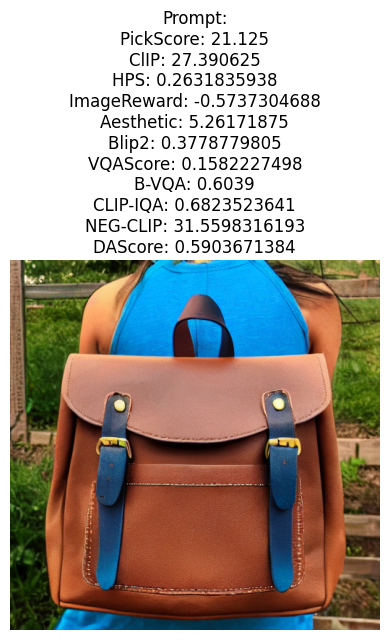

In [ ]:
import matplotlib.pyplot as plt

sample = df.iloc[0]

img_path =  IMAGE_PATH + sample["image_name"]
prompt = sample["prompt"]
file_path_csv = '/content/drive/MyDrive/Results/scores.csv'
run_models = False

if run_models:
  pickscore_sl = score_loss_extractor(pick_score, img_path, prompt)
  clip_sl = score_loss_extractor(clip_score, img_path, prompt)
  hps_sl = score_loss_extractor(hps, img_path, prompt)
  imagereward_sl = score_loss_extractor(image_reward, img_path, prompt)
  aesthetic_sl = score_loss_extractor(aesthetic, img_path, prompt)
  blip2_sl = score_loss_extractor(blip2, img_path, prompt)
  vqascore_sl = score_loss_extractor(vqascore, img_path, prompt)
  bvqascore_sl = score_loss_extractor(bvqa, img_path, prompt)
else:
  if os.path.isfile(file_path_csv):
    df_scores = pd.read_csv(file_path_csv)
    pickscore_sl = [df_scores['pickscore'][0]]
    clip_sl = [df_scores['CLIP'][0]]
    hps_sl = [df_scores['HPS'][0]]
    imagereward_sl = [df_scores['ImageReward'][0]]
    aesthetic_sl = [df_scores['Aesthetic'][0]]
    blip2_sl = [df_scores['BLIP2'][0]]
    vqascore_sl = [df_scores['VQAScore'][0]]
    bvqascore_sl = [df_scores['B-VQA'][0]]
    clipiqa_sl = [df_scores['CLIP-IQA'][0]]
    negclip_sl = [df_scores['NEG-CLIP'][0]]
    dascore_sl = [df_scores['DAscore'][0]]

  else:
    print("Dataframe doesn't exist.")

plt.imshow(Image.open(img_path))
plt.title(f"Prompt:\nPickScore: {pickscore_sl[0]}\nClIP: {clip_sl[0]}\nHPS: {hps_sl[0]}\nImageReward: {imagereward_sl[0]}\nAesthetic: {aesthetic_sl[0]}\nBlip2: {blip2_sl[0]}\nVQAScore: {vqascore_sl[0]}\nB-VQA: {bvqascore_sl[0]}\nCLIP-IQA: {clipiqa_sl[0]}\nNEG-CLIP: {negclip_sl[0]}\nDAScore: {dascore_sl[0]}")
plt.axis('off')
plt.show()



In [ ]:
import json
import os.path
import pandas as pd

json_with_scores = {}
file_path = '/content/drive/MyDrive/Results/scores.json'


if os.path.isfile(file_path):
  with open(file_path, 'r') as f:
    json_with_scores = json.load(f)


else:
  for index, row in df.iterrows():
    prompt = row.prompt
    img_path = IMAGE_PATH + row.image_name

    json_with_scores[index] =     {
          "image_name": row.image_name,
          "category": row.category,
          "method": row.method,
          "prompt": row.prompt,
          "score": row.score,
          "pickscore": float(score_loss_extractor(pickScoreLoss, img_path, prompt)[0]),
          "CLIP": float(score_loss_extractor(clipLoss, img_path, prompt)[0]),
          "HPS": float(score_loss_extractor(hpsLoss, img_path, prompt)[0]),
          "ImageReward": float(score_loss_extractor(imageRewardLoss, img_path, prompt)[0]),
          "Aesthetic": float(score_loss_extractor(aestheticLoss, img_path, prompt)[0])
      }
    with open(file_path, 'w') as f:
      json.dump(json_with_scores, f)


df_with_scores = pd.DataFrame(json_with_scores)

In [ ]:
df_with_scores.head()

,image_name,category,method,prompt,score,pickscore,CLIP,HPS,ImageReward,Aesthetic,BLIP2,B-VQA,CLIP-IQA,DAscore,NEG-CLIP,VQAScore,TIFA
0,0_0_00.png,color,Stable Diffusion v1.4,a brown backpack and a blue cow,3.000000,21.125000,27.390625,0.263184,-0.573730,5.261719,0.377878,0.6039,0.682352,0.590367,31.559832,0.158223,0.5
1,0_0_01.png,color,Stable Diffusion v1.4,a brown backpack and a blue cow,2.333333,21.671875,35.343750,0.273438,-1.236328,5.210938,0.383867,0.0342,0.312247,0.438460,31.131107,0.160714,0.5
2,0_0_02.png,color,Stable Diffusion v1.4,a brown bear and a red book,3.000000,21.187500,26.484375,0.233032,-1.043945,5.332031,0.412646,0.0601,0.387428,0.469847,27.715954,0.237520,0.4
3,0_0_03.png,color,Stable Diffusion v1.4,a brown bear and a red book,3.000000,19.968750,21.281250,0.193115,-1.603516,5.683594,0.358967,0.4141,0.603878,0.572439,25.074505,0.117581,0.4
4,0_0_04.png,color,Stable Diffusion v1.4,a red bear and a brown book,3.000000,23.312500,38.062500,0.326904,1.414062,5.523438,0.466394,0.7320,0.766401,0.561880,34.973732,0.972907,0.6


## Analysis

In [1]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


### Value Ranges

In [ ]:
min_pickscore, max_pickscore = get_range_score(df_with_scores, "pickscore")

In [ ]:
human_score_5 = pd.DataFrame(df_with_scores[df_with_scores["score"] == 5])

In [ ]:
human_score_5.head()

,image_name,category,method,prompt,score,pickscore,CLIP,HPS,ImageReward,Aesthetic,BLIP2,B-VQA,CLIP-IQA,DAscore,NEG-CLIP,VQAScore
10,0_0_10.png,color,Stable Diffusion v1.4,a green banana and a red suitcase,5.0,21.843750,41.12500,0.274170,1.097656,4.968750,0.452581,0.9756,0.206990,0.898992,35.575096,0.931192
13,0_0_13.png,color,Stable Diffusion v1.4,a brown sheep and a blue vase,5.0,23.171875,49.56250,0.320801,1.969727,5.593750,0.475754,0.9959,0.690929,0.877982,38.660763,0.977310
18,0_0_18.png,color,Stable Diffusion v1.4,a blue bear and a brown vase,5.0,21.921875,42.90625,0.281738,1.952148,5.246094,0.449391,0.9987,0.522275,0.892203,31.871935,0.815378
22,0_0_22.png,color,Stable Diffusion v1.4,a blue giraffe and a brown vase,5.0,20.859375,36.15625,0.291504,1.737305,5.046875,0.504841,0.9990,0.410139,0.892111,34.098667,0.953739
26,0_0_26.png,color,Stable Diffusion v1.4,a brown acorn and a green leaf,5.0,21.031250,32.09375,0.225830,0.019196,5.523438,0.427873,0.9971,0.151179,0.882474,35.469715,0.958876


In [ ]:
human_score_1 = pd.DataFrame(df_with_scores[df_with_scores["score"] == 1])

In [ ]:
human_score_1.head()

,image_name,category,method,prompt,score,pickscore,CLIP,HPS,ImageReward,Aesthetic,BLIP2,B-VQA,CLIP-IQA,DAscore,NEG-CLIP,VQAScore
19,0_0_19.png,color,Stable Diffusion v1.4,a blue bear and a brown vase,1.0,20.875000,37.375000,0.281250,1.492188,5.160156,0.494091,0.9936,0.462837,0.708722,32.025391,0.649440
35,0_0_35.png,color,Stable Diffusion v1.4,a red school bus and a green bag,1.0,19.546875,24.187500,0.189331,-2.273438,5.500000,0.274821,0.1060,0.241228,0.135208,32.424301,0.084691
158,0_3_08.png,color,Composable Diffusion v2,a blue cake and a red suitcase,1.0,20.453125,31.000000,0.228149,-2.123047,5.281250,0.351707,0.0051,0.417087,0.300790,28.085554,0.142942
175,0_3_25.png,color,Composable Diffusion v2,a brown chair and a red sheep,1.0,21.843750,29.781250,0.251709,-2.080078,4.988281,0.388538,0.6023,0.403562,0.517740,32.118191,0.140726
180,0_3_30.png,color,Composable Diffusion v2,a green tree and a brown grass,1.0,20.609375,23.703125,0.162109,-2.277344,4.769531,0.295409,0.1836,0.067702,0.149633,21.840311,0.375135


### Correlation

#### Utils

In [2]:
from scipy.stats import kendalltau, pearsonr, spearmanr
import pandas as pd
import os

In [3]:
scores = ['pickscore', 'CLIP', 'HPS', 'ImageReward', 'Aesthetic', 'BLIP2',
       'B-VQA', 'CLIP-IQA', 'DAscore', 'NEG-CLIP', 'VQAScore', 'TIFA']

In [4]:
# file_path_csv = '/content/drive/MyDrive/Results/scores.csv'
path = '/content/drive/MyDrive/Compositional Generation/Noise Optimization/Results/'
file_path_csv = path + 'scores.csv'

if os.path.isfile(file_path_csv):
  df_scores = pd.read_csv(file_path_csv, index_col=0)
else:
    print("Dataframe doesn't exist.")


In [5]:
df_scores.category.unique()

array(['color', 'shape', 'texture', '2d-spatial relationship',
       'non-spatial relationship', 'complex', '3d-spatial relationship',
       'numeracy'], dtype=object)

In [6]:
da_categories = ['color', 'shape', 'texture', '2d-spatial relationship', 'non-spatial relationship', 'complex']

In [7]:
def get_correlation(df_scores):
  corr_results = {'metric': [], 'pearson': [], 'kendall': [], 'spearman': []}
  p_results = {'metric': [], 'pearson_p': [], 'kendall_p': [], 'spearman_p': []}

  for s in scores:
    if s=='DAscore' and (df_scores['category'].isin(da_categories) == True).eq(False).any(): # All prompt set is not available
      tau, kendall_p_value = float("nan"), float("nan")
      corr_coef, pearson_p_value = float("nan"), float("nan")
      rho, spearman_p_value = float("nan"), float("nan")
    else:
      tau, kendall_p_value = kendalltau(df_scores['score'], df_scores[s])
      corr_coef, pearson_p_value = pearsonr(df_scores['score'], df_scores[s])
      rho, spearman_p_value = spearmanr(df_scores['score'], df_scores[s])

    corr_results['metric'].append(s)
    corr_results['pearson'].append(corr_coef)
    corr_results['kendall'].append(tau)
    corr_results['spearman'].append(rho)

    p_results['metric'].append(s)
    p_results['pearson_p'].append(pearson_p_value)
    p_results['kendall_p'].append(kendall_p_value)
    p_results['spearman_p'].append(spearman_p_value)

  correlation_df = pd.DataFrame(corr_results)
  correlation_df.set_index('metric', inplace=True)

  p_df = pd.DataFrame(p_results)
  p_df.set_index('metric', inplace=True)

  return correlation_df, p_df

#### Category Specific

In [ ]:
df_scores.category.unique()

array(['color', 'shape', 'texture', '2d-spatial relationship',
       'non-spatial relationship', 'complex', '3d-spatial relationship',
       'numeracy'], dtype=object)

##### Color

In [ ]:
color_correlation_df, color_p_df = get_correlation(df_scores.loc[df_scores['category'] == 'color'])

In [ ]:
color_correlation_df

,pearson,kendall,spearman
metric,,,
pickscore,0.226620,0.192803,0.263144
CLIP,0.275128,0.207745,0.282338
HPS,0.239852,0.157394,0.219262
ImageReward,0.584583,0.433593,0.580333
Aesthetic,0.077922,0.039110,0.056025
BLIP2,0.259108,0.178497,0.249776
B-VQA,0.621359,0.455640,0.609538
CLIP-IQA,0.113901,0.065064,0.092147
DAscore,0.793128,0.602894,0.771826


In [ ]:
color_p_df

,pearson_p,kendall_p,spearman_p
metric,,,
pickscore,7.481240e-05,3.095347e-06,3.829070e-06
CLIP,1.303844e-06,4.714210e-07,6.649573e-07
HPS,2.687246e-05,1.359709e-04,1.288918e-04
ImageReward,6.860740e-29,7.075566e-26,2.110084e-28
Aesthetic,1.782821e-01,3.432784e-01,3.334965e-01
BLIP2,5.440498e-06,1.484156e-05,1.198941e-05
B-VQA,1.980618e-33,2.356041e-28,6.619273e-32
CLIP-IQA,4.872344e-02,1.144056e-01,1.112125e-01
DAscore,3.907185e-66,1.846630e-48,1.487474e-60


##### Shape

In [ ]:
shape_correlation_df, shape_p_df = get_correlation(df_scores.loc[df_scores['category'] == 'shape'])

In [ ]:
shape_correlation_df

,pearson,kendall,spearman
metric,,,
pickscore,0.263048,0.192434,0.269781
CLIP,0.275851,0.210847,0.290637
HPS,0.457129,0.326323,0.439880
ImageReward,0.554809,0.387746,0.520481
Aesthetic,0.194963,0.137876,0.194841
BLIP2,0.333376,0.203202,0.287034
B-VQA,0.347893,0.279482,0.388090
CLIP-IQA,0.079588,0.055111,0.077551
DAscore,0.464006,0.337318,0.463032


In [ ]:
shape_p_df

,pearson_p,kendall_p,spearman_p
metric,,,
pickscore,3.861483e-06,2.778642e-06,2.122130e-06
CLIP,1.219765e-06,2.689356e-07,2.991296e-07
HPS,6.762066e-17,1.700786e-15,1.258339e-15
ImageReward,1.289610e-25,2.912849e-21,3.158406e-22
Aesthetic,6.852852e-04,7.726631e-04,6.907436e-04
BLIP2,3.212381e-09,7.008344e-07,4.244877e-07
B-VQA,5.824271e-10,8.945862e-12,3.194538e-12
CLIP-IQA,1.691547e-01,1.784573e-01,1.803655e-01
DAscore,2.011593e-17,1.787180e-16,2.392320e-17


##### Texture

In [ ]:
texture_correlation_df, texture_p_df = get_correlation(df_scores.loc[df_scores['category'] == 'texture'])

In [ ]:
texture_correlation_df

,pearson,kendall,spearman
metric,,,
pickscore,0.491658,0.373312,0.516367
CLIP,0.529903,0.392172,0.534614
HPS,0.555067,0.440969,0.600711
ImageReward,0.737020,0.549063,0.733984
Aesthetic,0.068150,0.054018,0.077796
BLIP2,0.540745,0.389424,0.546164
B-VQA,0.643871,0.511558,0.689618
CLIP-IQA,0.018935,-0.001625,-0.001224
DAscore,0.673949,0.534048,0.710977


In [ ]:
texture_p_df

,pearson_p,kendall_p,spearman_p
metric,,,
pickscore,1.154398e-19,1.064447e-19,7.591972e-22
CLIP,4.050183e-23,1.214967e-21,1.415636e-23
HPS,1.211940e-25,6.258630e-27,8.273492e-31
ImageReward,1.244840e-52,7.153632e-41,5.327347e-52
Aesthetic,2.392619e-01,1.884278e-01,1.789872e-01
BLIP2,3.514959e-24,2.179696e-21,1.001861e-24
B-VQA,1.612108e-36,1.131003e-35,1.141392e-43
CLIP-IQA,7.439536e-01,9.683919e-01,9.831506e-01
DAscore,4.480367e-41,9.088700e-39,1.751958e-47


##### 2d-spatial relationship

In [ ]:
s2d_correlation_df, s2d_p_df = get_correlation(df_scores.loc[df_scores['category'] == '2d-spatial relationship'])

In [ ]:
s2d_correlation_df

,pearson,kendall,spearman
metric,,,
pickscore,0.313738,0.229141,0.299295
CLIP,0.344553,0.287323,0.369452
HPS,0.431216,0.315138,0.410295
ImageReward,0.403252,0.310414,0.393554
Aesthetic,0.151843,0.104007,0.135603
BLIP2,0.343552,0.286100,0.368770
B-VQA,0.237136,0.195421,0.254654
CLIP-IQA,0.069866,0.068240,0.088428
DAscore,0.324482,0.247476,0.317878


In [ ]:
s2d_p_df

,pearson_p,kendall_p,spearman_p
metric,,,
pickscore,2.820393e-08,2.437061e-07,1.264516e-07
CLIP,8.694483e-10,9.122943e-11,3.905241e-11
HPS,5.139254e-15,1.157064e-12,1.306876e-13
ImageReward,3.696604e-13,2.430056e-12,1.487098e-12
Aesthetic,8.430769e-03,1.902279e-02,1.878498e-02
BLIP2,9.795696e-10,1.053016e-10,4.267192e-11
B-VQA,3.331851e-05,1.033103e-05,7.963124e-06
CLIP-IQA,2.276117e-01,1.234119e-01,1.264585e-01
DAscore,8.760414e-09,2.308307e-08,1.807209e-08


##### Non-spatial relationship

In [ ]:
ns_correlation_df, ns_p_df = get_correlation(df_scores.loc[df_scores['category'] == 'non-spatial relationship'])

In [ ]:
ns_correlation_df

,pearson,kendall,spearman
metric,,,
pickscore,0.557817,0.340597,0.431611
CLIP,0.651136,0.347143,0.438852
HPS,0.622650,0.428305,0.535189
ImageReward,0.542620,0.408107,0.511855
Aesthetic,0.095076,0.047198,0.061489
BLIP2,0.619944,0.279805,0.353065
B-VQA,0.462029,0.292816,0.370851
CLIP-IQA,0.015444,0.062880,0.081861
DAscore,0.519497,0.356627,0.452612


In [ ]:
ns_p_df

,pearson_p,kendall_p,spearman_p
metric,,,
pickscore,6.230305e-26,2.786103e-14,4.823928e-15
CLIP,1.426534e-37,8.354736e-15,1.490067e-15
HPS,1.337558e-33,9.449220e-22,1.243805e-23
ImageReward,2.282864e-24,6.433671e-20,1.959285e-21
Aesthetic,1.002564e-01,2.913723e-01,2.884229e-01
BLIP2,3.038626e-33,3.726404e-10,3.102341e-10
B-VQA,2.858332e-17,5.838171e-11,3.254005e-11
CLIP-IQA,7.899322e-01,1.591498e-01,1.572675e-01
DAscore,3.899666e-22,1.402949e-15,1.477763e-16


##### Complex

In [ ]:
complex_correlation_df, complex_p_df = get_correlation(df_scores.loc[df_scores['category'] == 'complex'])

In [ ]:
complex_correlation_df

,pearson,kendall,spearman
metric,,,
pickscore,0.204604,0.121534,0.167428
CLIP,0.348840,0.201468,0.275957
HPS,0.354797,0.201466,0.270438
ImageReward,0.496116,0.313381,0.423870
Aesthetic,0.076943,0.036742,0.051231
BLIP2,0.298934,0.169568,0.235009
B-VQA,0.425938,0.267122,0.371652
CLIP-IQA,0.022582,0.018361,0.026547
DAscore,0.512540,0.363804,0.488132


In [ ]:
complex_p_df

,pearson_p,kendall_p,spearman_p
metric,,,
pickscore,3.612868e-04,3.466574e-03,3.632983e-03
CLIP,5.194541e-10,1.214966e-06,1.207832e-06
HPS,2.505937e-10,1.200970e-06,1.999854e-06
ImageReward,4.804130e-20,4.137076e-14,1.642411e-14
Aesthetic,1.838151e-01,3.761555e-01,3.765790e-01
BLIP2,1.311532e-07,4.328881e-05,3.936015e-05
B-VQA,1.187629e-14,1.190127e-10,2.930411e-11
CLIP-IQA,6.968732e-01,6.579208e-01,6.469705e-01
DAscore,1.698299e-21,1.735991e-18,2.288240e-19


##### 3d-spatial relationship

In [ ]:
s3d_correlation_df, s3d_p_df = get_correlation(df_scores.loc[df_scores['category'] == '3d-spatial relationship'])

In [ ]:
s3d_correlation_df

,pearson,kendall,spearman
metric,,,
pickscore,0.174531,0.100195,0.139074
CLIP,0.306303,0.223667,0.314912
HPS,0.459935,0.305438,0.416430
ImageReward,0.405363,0.294252,0.401461
Aesthetic,0.096596,0.083287,0.122862
BLIP2,0.411916,0.302977,0.416133
B-VQA,0.334990,0.230803,0.329516
CLIP-IQA,0.107870,0.067996,0.097519
DAscore,NaN,NaN,NaN


In [ ]:
s3d_p_df

,pearson_p,kendall_p,spearman_p
metric,,,
pickscore,2.415986e-03,1.569682e-02,1.593039e-02
CLIP,6.168070e-08,6.595330e-08,2.487795e-08
HPS,4.137093e-17,1.640862e-13,5.178440e-14
ImageReward,2.713739e-13,1.153775e-12,4.796902e-13
Aesthetic,9.491513e-02,4.434264e-02,3.340195e-02
BLIP2,1.025216e-13,2.436556e-13,5.418105e-14
B-VQA,2.668393e-09,2.454397e-08,4.984817e-09
CLIP-IQA,6.203985e-02,1.003127e-01,9.178561e-02
DAscore,NaN,NaN,NaN


##### Numeracy

In [ ]:
num_correlation_df, num_p_df = get_correlation(df_scores.loc[df_scores['category'] == 'numeracy'])

In [ ]:
num_correlation_df

,pearson,kendall,spearman
metric,,,
pickscore,0.376341,0.240954,0.336639
CLIP,0.209561,0.154265,0.222860
HPS,0.495121,0.345736,0.471234
ImageReward,0.481950,0.348838,0.483612
Aesthetic,0.061399,0.026266,0.035990
BLIP2,0.363560,0.263844,0.366359
B-VQA,0.460015,0.321908,0.443840
CLIP-IQA,0.017947,0.045310,0.067707
DAscore,NaN,NaN,NaN


In [ ]:
num_p_df

,pearson_p,kendall_p,spearman_p
metric,,,
pickscore,1.577011e-11,4.041674e-09,2.205354e-09
CLIP,2.569633e-04,1.611739e-04,9.900749e-05
HPS,5.849451e-20,2.728762e-17,5.459388e-18
ImageReward,7.454357e-19,1.359920e-17,5.438760e-19
Aesthetic,2.891367e-01,5.207042e-01,5.346264e-01
BLIP2,8.340237e-11,1.052825e-10,5.827517e-11
B-VQA,4.079049e-17,3.275842e-15,6.525747e-16
CLIP-IQA,7.568857e-01,2.673302e-01,2.423350e-01
DAscore,NaN,NaN,NaN


##### Overall
(now just DA categories)

In [ ]:
correlation_df, p_df = get_correlation(df_scores.loc[df_scores['category'].isin(da_categories)])

In [ ]:
correlation_df

,pearson,kendall,spearman
metric,,,
pickscore,0.063242,0.077191,0.110080
CLIP,0.264317,0.189268,0.265524
HPS,0.256578,0.211425,0.292304
ImageReward,0.439786,0.353665,0.476347
Aesthetic,0.072803,0.054014,0.077368
BLIP2,0.198262,0.166873,0.233710
B-VQA,0.393168,0.334009,0.458597
CLIP-IQA,0.105876,0.062738,0.089325
DAscore,0.493864,0.401927,0.555470


In [ ]:
p_df

,pearson_p,kendall_p,spearman_p
metric,,,
pickscore,7.275596e-03,3.614010e-06,2.850575e-06
CLIP,3.739149e-30,5.506661e-30,2.005269e-30
HPS,1.878777e-28,5.282755e-37,8.615654e-37
ImageReward,5.130246e-86,2.042655e-100,1.307689e-102
Aesthetic,1.996782e-03,1.175426e-03,1.019473e-03
BLIP2,2.064304e-17,1.036071e-23,9.369961e-24
B-VQA,1.306763e-67,1.042437e-89,2.661488e-94
CLIP-IQA,6.748905e-06,1.606623e-04,1.478334e-04
DAscore,2.642694e-111,3.820168e-129,2.992014e-146


In [ ]:
correlation_df.to_csv(path+'correlations.csv')
p_df.to_csv(path+'p_values.csv')

#### Category Specific **Stable Diffusion**

In [10]:
df_scores.method.unique()

array(['Stable Diffusion v1.4', 'Stable Diffusion v2',
       'Structure Diffusion v2', 'Composable Diffusion v2',
       'Attend-and-Excite v2', 'GORS'], dtype=object)

In [11]:
sd_models = ['Stable Diffusion v1.4', 'Stable Diffusion v2']
sd_df = df_scores.loc[df_scores['method'].isin(sd_models)]
sd_df.head()

,image_name,category,method,prompt,score,pickscore,CLIP,HPS,ImageReward,Aesthetic,BLIP2,B-VQA,CLIP-IQA,DAscore,NEG-CLIP,VQAScore,TIFA
0,0_0_00.png,color,Stable Diffusion v1.4,a brown backpack and a blue cow,3.000000,21.125000,27.390625,0.263184,-0.573730,5.261719,0.377878,0.6039,0.682352,0.590367,31.559832,0.158223,0.5
1,0_0_01.png,color,Stable Diffusion v1.4,a brown backpack and a blue cow,2.333333,21.671875,35.343750,0.273438,-1.236328,5.210938,0.383867,0.0342,0.312247,0.438460,31.131107,0.160714,0.5
2,0_0_02.png,color,Stable Diffusion v1.4,a brown bear and a red book,3.000000,21.187500,26.484375,0.233032,-1.043945,5.332031,0.412646,0.0601,0.387428,0.469847,27.715954,0.237520,0.4
3,0_0_03.png,color,Stable Diffusion v1.4,a brown bear and a red book,3.000000,19.968750,21.281250,0.193115,-1.603516,5.683594,0.358967,0.4141,0.603878,0.572439,25.074505,0.117581,0.4
4,0_0_04.png,color,Stable Diffusion v1.4,a red bear and a brown book,3.000000,23.312500,38.062500,0.326904,1.414062,5.523438,0.466394,0.7320,0.766401,0.561880,34.973732,0.972907,0.6


In [44]:
sd_df.shape

(800, 17)

##### Color

In [16]:
color_correlation_df, color_p_df = get_correlation(sd_df.loc[sd_df['category'] == 'color'])

In [45]:
color_correlation_df

,pearson,kendall,spearman
metric,,,
pickscore,0.197053,0.159880,0.228624
CLIP,0.190899,0.148932,0.189926
HPS,0.149460,0.100457,0.140812
ImageReward,0.526998,0.404196,0.536745
Aesthetic,-0.158850,-0.122784,-0.180457
BLIP2,0.218528,0.143807,0.202610
B-VQA,0.644019,0.554982,0.704060
CLIP-IQA,0.100284,0.063012,0.092045
DAscore,0.825305,0.689176,0.845212


In [18]:
color_p_df

,pearson_p,kendall_p,spearman_p
metric,,,
pickscore,4.940613e-02,2.743058e-02,2.214435e-02
CLIP,5.710299e-02,3.946646e-02,5.840533e-02
HPS,1.377680e-01,1.651113e-01,1.622977e-01
ImageReward,1.774740e-08,2.250360e-08,8.589697e-09
Aesthetic,1.144355e-01,9.007981e-02,7.238948e-02
BLIP2,2.894204e-02,4.665781e-02,4.321295e-02
B-VQA,4.894769e-13,1.689627e-14,3.055356e-16
CLIP-IQA,3.208392e-01,3.833784e-01,3.623946e-01
DAscore,4.610804e-26,1.514806e-21,2.041390e-28


##### Shape

In [19]:
shape_correlation_df, shape_p_df = get_correlation(sd_df.loc[sd_df['category'] == 'shape'])

In [20]:
shape_correlation_df

,pearson,kendall,spearman
metric,,,
pickscore,0.260855,0.190480,0.260931
CLIP,0.199666,0.150791,0.213937
HPS,0.407136,0.298687,0.396057
ImageReward,0.485159,0.341611,0.455975
Aesthetic,0.331214,0.231087,0.324669
BLIP2,0.299212,0.189449,0.265148
B-VQA,0.320508,0.239499,0.322390
CLIP-IQA,0.006543,0.005388,0.006643
DAscore,0.434801,0.319627,0.436028


In [21]:
shape_p_df

,pearson_p,kendall_p,spearman_p
metric,,,
pickscore,8.759512e-03,0.007866,0.008739
CLIP,4.640821e-02,0.035186,0.032575
HPS,2.624819e-05,0.000030,0.000045
ImageReward,3.126467e-07,0.000002,0.000002
Aesthetic,7.625536e-04,0.001250,0.000982
BLIP2,2.493680e-03,0.008085,0.007675
B-VQA,1.150005e-03,0.000815,0.001071
CLIP-IQA,9.484898e-01,0.939955,0.947701
DAscore,6.174422e-06,0.000008,0.000006


##### Texture

In [22]:
texture_correlation_df, texture_p_df = get_correlation(sd_df.loc[sd_df['category'] == 'texture'])

In [23]:
texture_correlation_df

,pearson,kendall,spearman
metric,,,
pickscore,0.468875,0.355621,0.491031
CLIP,0.494492,0.347434,0.478555
HPS,0.539414,0.403408,0.559337
ImageReward,0.673718,0.491418,0.659239
Aesthetic,0.018120,0.033178,0.044791
BLIP2,0.498783,0.361033,0.510131
B-VQA,0.694699,0.522884,0.686428
CLIP-IQA,-0.014988,-0.032704,-0.050968
DAscore,0.676392,0.519388,0.696570


In [24]:
texture_p_df

,pearson_p,kendall_p,spearman_p
metric,,,
pickscore,8.645756e-07,6.823629e-07,2.138369e-07
CLIP,1.703679e-07,1.188056e-06,4.753081e-07
HPS,7.013055e-09,1.666308e-08,1.457993e-09
ImageReward,1.578118e-14,6.067218e-12,8.836696e-14
Aesthetic,8.579852e-01,6.428024e-01,6.581252e-01
BLIP2,1.280888e-07,4.345885e-07,5.909823e-08
B-VQA,1.086744e-15,2.521491e-13,3.204807e-15
CLIP-IQA,8.823381e-01,6.471432e-01,6.145451e-01
DAscore,1.135929e-14,3.606987e-13,8.465145e-16


##### 2d-spatial relationship

In [25]:
s2d_correlation_df, s2d_p_df = get_correlation(sd_df.loc[sd_df['category'] == '2d-spatial relationship'])

In [26]:
s2d_correlation_df

,pearson,kendall,spearman
metric,,,
pickscore,0.373357,0.303388,0.381901
CLIP,0.404612,0.357751,0.459509
HPS,0.497247,0.424142,0.550301
ImageReward,0.389326,0.316972,0.405293
Aesthetic,0.309963,0.266429,0.338829
BLIP2,0.372130,0.323603,0.411133
B-VQA,0.182174,0.150084,0.197797
CLIP-IQA,0.014755,-0.003766,-0.007336
DAscore,0.210459,0.153835,0.198137


In [27]:
s2d_p_df

,pearson_p,kendall_p,spearman_p
metric,,,
pickscore,1.302748e-04,9.886653e-05,8.829557e-05
CLIP,2.976572e-05,4.354359e-06,1.516125e-06
HPS,1.419254e-07,5.026316e-08,3.010952e-09
ImageReward,6.242076e-05,4.589735e-05,2.877517e-05
Aesthetic,1.699094e-03,6.177115e-04,5.641660e-04
BLIP2,1.376335e-04,3.164928e-05,2.146196e-05
B-VQA,6.967100e-02,5.363665e-02,4.853708e-02
CLIP-IQA,8.841555e-01,9.613735e-01,9.422557e-01
DAscore,3.557647e-02,4.790806e-02,4.814359e-02


##### Non-spatial relationship

In [28]:
ns_correlation_df, ns_p_df = get_correlation(sd_df.loc[sd_df['category'] == 'non-spatial relationship'])

In [29]:
ns_correlation_df

,pearson,kendall,spearman
metric,,,
pickscore,0.320661,0.237900,0.299866
CLIP,0.364733,0.203107,0.255731
HPS,0.458519,0.316356,0.389550
ImageReward,0.467581,0.337479,0.409369
Aesthetic,0.069504,0.025523,0.033993
BLIP2,0.399286,0.243010,0.303148
B-VQA,0.341371,0.265610,0.331989
CLIP-IQA,0.055993,0.085147,0.106978
DAscore,0.471701,0.297081,0.368395


In [30]:
ns_p_df

,pearson_p,kendall_p,spearman_p
metric,,,
pickscore,1.143409e-03,0.003017,2.437190e-03
CLIP,1.908353e-04,0.011147,1.022854e-02
HPS,1.607264e-06,0.000077,6.176327e-05
ImageReward,9.352428e-07,0.000024,2.346336e-05
Aesthetic,4.919979e-01,0.749938,7.370590e-01
BLIP2,3.868829e-05,0.002371,2.170471e-03
B-VQA,5.093066e-04,0.000914,7.397933e-04
CLIP-IQA,5.800382e-01,0.286905,2.894277e-01
DAscore,7.273883e-07,0.000203,1.624844e-04


##### Complex

In [31]:
complex_correlation_df, complex_p_df = get_correlation(sd_df.loc[sd_df['category'] == 'complex'])

In [32]:
complex_correlation_df

,pearson,kendall,spearman
metric,,,
pickscore,0.227136,0.123536,0.163298
CLIP,0.268879,0.184777,0.258939
HPS,0.278480,0.193859,0.251470
ImageReward,0.516304,0.323814,0.434519
Aesthetic,0.133962,0.090363,0.125157
BLIP2,0.261729,0.197276,0.280390
B-VQA,0.417019,0.249831,0.358709
CLIP-IQA,-0.029150,-0.000879,0.001500
DAscore,0.543901,0.394991,0.520820


In [33]:
complex_p_df

,pearson_p,kendall_p,spearman_p
metric,,,
pickscore,2.305096e-02,8.980588e-02,1.045102e-01
CLIP,6.830734e-03,1.095098e-02,9.285315e-03
HPS,5.023687e-03,7.553980e-03,1.161017e-02
ImageReward,3.834055e-08,8.031947e-06,6.270363e-06
Aesthetic,1.839216e-01,2.131899e-01,2.147101e-01
BLIP2,8.528414e-03,6.532360e-03,4.719848e-03
B-VQA,1.588095e-05,5.738560e-04,2.475871e-04
CLIP-IQA,7.734226e-01,9.903340e-01,9.881839e-01
DAscore,4.967732e-09,5.162082e-08,2.778362e-08


##### 3d-spatial relationship

In [34]:
s3d_correlation_df, s3d_p_df = get_correlation(sd_df.loc[sd_df['category'] == '3d-spatial relationship'])

In [35]:
s3d_correlation_df

,pearson,kendall,spearman
metric,,,
pickscore,0.190134,0.085261,0.113443
CLIP,0.285549,0.180000,0.253537
HPS,0.421168,0.244351,0.330935
ImageReward,0.332709,0.210028,0.282741
Aesthetic,0.105584,0.096304,0.136492
BLIP2,0.358781,0.220891,0.304008
B-VQA,0.291949,0.183812,0.253885
CLIP-IQA,-0.013243,0.040286,0.054326
DAscore,NaN,NaN,NaN


In [36]:
s3d_p_df

,pearson_p,kendall_p,spearman_p
metric,,,
pickscore,0.058124,0.247244,0.261096
CLIP,0.003979,0.014433,0.010921
HPS,0.000013,0.000899,0.000771
ImageReward,0.000719,0.004297,0.004368
Aesthetic,0.295797,0.190935,0.175701
BLIP2,0.000247,0.002671,0.002105
B-VQA,0.003206,0.012468,0.010808
CLIP-IQA,0.895955,0.583885,0.591387
DAscore,NaN,NaN,NaN


##### Numeracy

In [37]:
num_correlation_df, num_p_df = get_correlation(sd_df.loc[sd_df['category'] == 'numeracy'])

In [38]:
num_correlation_df

,pearson,kendall,spearman
metric,,,
pickscore,0.344290,0.208479,0.286651
CLIP,0.113640,0.089559,0.124770
HPS,0.497959,0.359062,0.489691
ImageReward,0.428622,0.312511,0.431921
Aesthetic,0.072757,0.029592,0.037117
BLIP2,0.285689,0.188911,0.265067
B-VQA,0.463016,0.337279,0.462897
CLIP-IQA,0.103987,0.077635,0.106611
DAscore,NaN,NaN,NaN


In [39]:
num_p_df

,pearson_p,kendall_p,spearman_p
metric,,,
pickscore,4.523523e-04,3.617873e-03,3.835192e-03
CLIP,2.602675e-01,2.103907e-01,2.161410e-01
HPS,1.353410e-07,5.113101e-07,2.333484e-07
ImageReward,8.625786e-06,1.225208e-05,7.221633e-06
Aesthetic,4.719064e-01,6.792473e-01,7.138958e-01
BLIP2,3.960608e-03,8.199559e-03,7.694451e-03
B-VQA,1.230952e-06,2.357262e-06,1.239724e-06
CLIP-IQA,3.032029e-01,2.772718e-01,2.910961e-01
DAscore,NaN,NaN,NaN


##### Overall
(now just DA categories)

In [40]:
correlation_df, p_df = get_correlation(sd_df.loc[sd_df['category'].isin(da_categories)])

In [41]:
correlation_df

,pearson,kendall,spearman
metric,,,
pickscore,0.035874,0.068157,0.096961
CLIP,0.215933,0.165161,0.228866
HPS,0.205875,0.177411,0.241370
ImageReward,0.418575,0.339378,0.453845
Aesthetic,0.100032,0.066490,0.095682
BLIP2,0.174237,0.175884,0.241596
B-VQA,0.387800,0.350394,0.472405
CLIP-IQA,0.098789,0.052857,0.074120
DAscore,0.470794,0.395009,0.542971


In [42]:
p_df

,pearson_p,kendall_p,spearman_p
metric,,,
pickscore,3.803939e-01,1.847639e-02,1.751576e-02
CLIP,9.225250e-08,1.073184e-08,1.429748e-08
HPS,3.638278e-07,8.053121e-10,2.114440e-09
ImageReward,7.512560e-27,6.253110e-32,8.019774e-32
Aesthetic,1.423347e-02,2.138961e-02,1.906740e-02
BLIP2,1.771519e-05,1.093121e-09,2.040451e-09
B-VQA,5.722703e-23,6.656191e-34,1.108257e-34
CLIP-IQA,1.549064e-02,6.699162e-02,6.963661e-02
DAscore,1.994861e-34,1.182780e-42,2.624551e-47


In [43]:
correlation_df.to_csv(path+'correlations.csv')
p_df.to_csv(path+'p_values.csv')